### Lecture 5: [Coding Exercise] GP-WGAN

#### GPU Support

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


device

device(type='cuda')

#### Global Hyper-parameters

In [ ]:
noise_dim = 100
num_epochs = 10
num_steps = 10
learning_rate = 0.0001
betas = (0, 0.9)
Lambda_value = 10
K_steps = 5
batch_size = 256

#### Generator Model

In [ ]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=noise_dim,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 4
            torch.nn.Linear(
                in_features=240,
                out_features=784,
                bias=True
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

#### Maxout Activation

##### Source: https://github.com/pytorch/pytorch/issues/805

In [ ]:
class Maxout(torch.nn.Module):

    def __init__(self, num_pieces):

        super(Maxout, self).__init__()

        self.num_pieces = num_pieces

    def forward(self, x):

        # x.shape = (batch_size? x 625)

        assert x.shape[1] % self.num_pieces == 0  # 625 % 5 = 0

        ret = x.view(
            *x.shape[:1],  # batch_size
            x.shape[1] // self.num_pieces,  # piece-wise linear
            self.num_pieces,  # num_pieces
            *x.shape[2:]  # remaining dimensions if any
        )
        
        # ret.shape = (batch_size? x 125 x 5)

        # https://pytorch.org/docs/stable/torch.html#torch.max        
        ret, _ = ret.max(dim=2)

        # ret.shape = (batch_size? x 125)

        return ret

#### Discriminator Model

In [ ]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=784,
                out_features=240,
                bias=True
            ),
            Maxout(5),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=48,
                out_features=240,
                bias=True
            ),
            Maxout(5),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=48,
                out_features=1,
                bias=True
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, batch):
        inputs = batch.view(batch.size(0), -1)
        outputs = self.fcn(inputs)
        return outputs

#### MNIST Dataset

In [ ]:
import torchvision

In [ ]:
class FlattenTransform:
    
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)
        

data_train = torchvision.datasets.MNIST(
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        FlattenTransform()
    ])
)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

#### GAN Optimizer

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


discriminator_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=learning_rate,
    betas=betas
)

generator_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr=learning_rate,
    betas=betas
)

#### Gradient Penalty Loss

In [ ]:
# Gradient Penalty Loss

'''
x: real data
y: generated data


torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False)
Computes and returns the sum of gradients of outputs w.r.t. the inputs.
'''
def calcGradientPenalty(x, y):

  # inspect inputs dimensions
  # print(x.shape, y.shape)
  # torch.Size([64, 1, 784]) torch.Size([64, 784])
  # remove the excess dimension
  x = torch.squeeze(x, dim=1)
  

  # combine real and generated images
  alpha = torch.rand(x.shape).to(device)
  interpolated = alpha * x + (1 - alpha) * y
  
  # convert combination to torch variable with gradients
  var_interpolated = torch.autograd.Variable(
      interpolated, requires_grad=True).to(device)

  # pass combination to the discriminator
  outputs = discriminator(var_interpolated)

  # find the gradients of the inputs
  gradients = torch.autograd.grad(
      outputs=outputs,
      inputs=var_interpolated,
      grad_outputs=torch.ones_like(outputs).to(device),
      retain_graph=True,
      create_graph=True,
      only_inputs=False,
      allow_unused=False
  )[0]

  # calculate the mean norm of the gradients
  grad_norm = gradients.norm(2, dim=1).mean()

  # calculate the deviation from the value one
  loss = (grad_norm - 1) ** 2

  # return the gradient penalty
  return loss


#### GAN Losss ( Binary Cross Entropy )

In [ ]:
criterion = torch.nn.BCELoss()

#### GAN Training

In [14]:
# valid and fake targets
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

# dataset iterator
data_iter = iter(train_loader)

# training epochs
for epoch in range(num_epochs):

  # Train Discriminator
  discriminator_loss = 0
  for k in range(K_steps):
    
    # load next mini-batch
    images, _ = next(data_iter)

    # put on GPU
    real_images = images.to(device)

    # pass random noise to generator
    fake_images = generator(
        torch.randn(batch_size, noise_dim).to(device)
    )
    
    # reset discriminator
    discriminator_optimizer.zero_grad()

    # get discriminator outputs on real and generated images
    real_outputs = discriminator(real_images)
    fake_outputs = discriminator(fake_images)

    # perform GAN criterion
    d_x = criterion(real_outputs, real_labels)
    d_g_z = criterion(fake_outputs, fake_labels)
    gan_loss = d_g_z - d_x

    # perform gradient penalty loss
    gradient_penalty = calcGradientPenalty(real_images, fake_images)

    # calculate total loss
    loss = gan_loss + Lambda_value * gradient_penalty

    # calculate gradients
    loss.backward()

    # update weights
    discriminator_optimizer.step()

    # log step loss
    discriminator_loss += loss

  # calculate average loss
  discriminator_loss /= K_steps


  # Train Generator

  # load next mini batch
  images, _ = next(data_iter)

  # put images on GPU
  real_images = images.to(device)

  # random noise vector
  z = torch.randn(batch_size, noise_dim).to(device)

  # reset generator
  generator.zero_grad()

  # generate fake images
  fake_images = generator(z)

  # get discriminator outputs on fake images
  outputs = discriminator(fake_images)

  # perform GAN criterion
  gan_loss = criterion(outputs, real_labels)

  # perform gradient penalty criterion
  gradient_penalty = calcGradientPenalty(real_images, fake_images)

  # calculate total loss
  loss = gan_loss + Lambda_value * gradient_penalty

  # calculate gradients
  loss.backward()

  # update weights
  generator_optimizer.step()

  # log loss
  generator_loss = loss

  # Log Results
  print("E:{},G:{},D:{}".format(
      epoch,
      generator_loss,
      discriminator_loss
  ))

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:136: UserWarning: only_inputs argument is deprecated and is ignored now (defaults to True). To accumulate gradient for other parts of the graph, please use torch.autograd.backward.
  warnings.warn("only_inputs argument is deprecated and is ignored now "


E:0,G:9.894877433776855,D:9.139516830444336
E:1,G:10.00295639038086,D:8.933562278747559
E:2,G:10.106285095214844,D:8.729666709899902
E:3,G:10.208581924438477,D:8.546061515808105
E:4,G:10.304879188537598,D:8.3726167678833
E:5,G:10.360466003417969,D:8.216313362121582
E:6,G:10.398161888122559,D:8.065155029296875
E:7,G:10.383990287780762,D:7.90920877456665
E:8,G:10.369281768798828,D:7.749558448791504
E:9,G:10.2871675491333,D:7.592796325683594


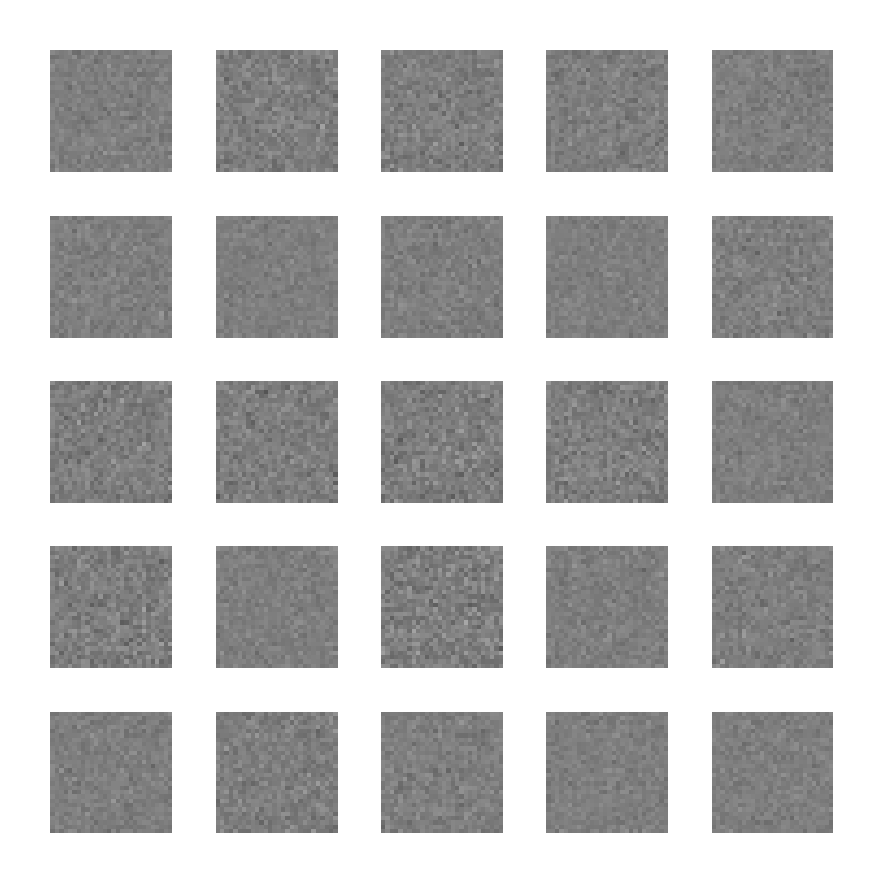

In [15]:
# Visualize Results
test_set = torch.randn(25, noise_dim).to(device)

generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1
)

img = np.transpose(
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(img);